In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

In [2]:
class HMM:
    def __init__(self, prior_model, trans_model, sensor_model):
        """
        :param prior_model: Column vector with prior probabilities for X_0
        :param trans_model: Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.
        I.e., the transition probabilities are given row-wise.
        :param sensor_model: Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the
        sensor probabilities are listed row-wise.
        """

        # Storage for model parameters
        self.prior_model = None
        self.trans_model = None
        self.diag_sensor_model = None
        self.num_hidden = None
        self.num_obs = None

        # Holds the log-likelihood of the model given the data
        self.ll = None

        # Storage for messages being send during inference
        self.forward_messages = None
        self.backward_messages = None
        self.forward_backward_messages = None

        # Initialize the data structures
        self.initialize(prior_model, trans_model, sensor_model)

    def initialize(self, prior_model, trans_model, sensor_model):
        """
          :param prior_model: Column vector with prior probabilities for X_0
          :param trans_model: Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.
          I.e., the transition probabilities are given row-wise.
          :param sensor_model: Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the
          sensor probabilities are listed row-wise.
          """

        self.prior_model = prior_model
        self.trans_model = trans_model

        # Extract the number of states for the hidden/state variable and the observation variable
        self.num_hidden = sensor_model.shape[0]
        self.num_obs = sensor_model.shape[1]

        # Convert the sensor model specification into diagonal form (see Slide 25)
        self.diag_sensor_model = []
        for i in range(self.num_obs):
            self.diag_sensor_model.append(np.diag(sensor_model[:, i]))

    # Do forward calculations: P(X_k|e_{1:k}). As a byproduct, we also get the log-likelihood of the model given the
    # data
    def forward(self, data):
        """
        :param data: list with entries of the observations
        """

        # Initialization
        total_time = len(data)
        self.forward_messages = np.zeros((self.num_hidden, total_time))

        # Do forward calculations
        #
        # We take special care of the first time step, where an observation is
        # assumed and no transition model is involved. Note that this differs a bit from the AIMA model from the
        # lecture
        self.forward_messages[:, 0] = np.dot(self.diag_sensor_model[data[0]], self.prior_model)

        # Calculate the log-likelihood (ll) contribution from the first time step
        self.ll = np.log2(np.sum(self.forward_messages[:, 0]))
        self.forward_messages[:, 0] = self.forward_messages[:, 0] / np.sum(self.forward_messages[:, 0])

        for t in range(1, total_time):
            temporal_term = np.dot(np.transpose(self.trans_model), self.forward_messages[:, t - 1])
            self.forward_messages[:, t] = np.dot(self.diag_sensor_model[data[t]], temporal_term)

            # Update ll
            self.ll += np.log2(np.sum(self.forward_messages[:, t]))

            # Normalize
            self.forward_messages[:, t] = self.forward_messages[:, t] / np.sum(self.forward_messages[:, t])

    # Do backward calculations: P(e_{k+1:t}|X_k)
    def backward(self, data):
        """
        :param data: list with entries of the observations
        """

        # Initialization
        total_time = len(data)
        self.backward_messages = np.zeros((self.num_hidden, total_time))
        self.backward_messages[:, total_time - 1] = np.ones(self.num_hidden)

        # Do backward calculations
        for t in range(total_time - 2, -1, -1):
            temp = np.dot(self.diag_sensor_model[data[t + 1]], self.backward_messages[:, t + 1])
            self.backward_messages[:, t] = np.dot(self.trans_model, temp)

            # Normalize (just to avoid numerical instability)
            self.backward_messages[:, t] = self.backward_messages[:, t] / np.sum(self.backward_messages[:, t])

    # The forward backward algorithm. It essentially just calls the forward and backward functions and normalizes the
    # results afterwards.
    def forward_backward(self, data):
        """
        :param data: list with entries of the observations
        """

        self.forward(data)
        self.backward(data)
        prob = self.forward_messages * self.backward_messages
        self.forward_backward_messages = prob / np.matlib.repmat(np.sum(prob, axis=0), self.num_hidden, 1)

    # Visualize the results
    def visualize(self, state, data=None):
        """
        :param state: Display the probability of the state 'state'
        :param data: The observations that have been made
        """
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        if self.forward_backward_messages is not None:
            ax1.plot(self.forward_backward_messages[state, :], label='Smooted estimate')
        if self.forward_messages is not None:
            ax1.plot(self.forward_messages[state, :], label='Filtered estimate')
        if data is not None:
            ax1.plot(data, label='Observations')
        plt.xticks(range(0,self.forward_messages.shape[1]))
        plt.xlabel("Time steps")
        plt.ylabel("P(X={}|evidence)".format(state))
        plt.title("Smoothed and filtered probabilities")
        ax1.legend(loc='best')

        fig.subplots_adjust(hspace=.5)
        plt.show()

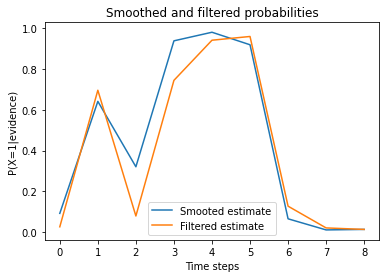

In [4]:
# Transition matrix with transModel(i, j)=P(X_t=j | X_{t-1}=i.I.e., the transition probabilities are given row-wise.
trans_model = np.array([[0.9, 0.1], [0.4, 0.6]])

# Column vector with prior probabilities for X_0
prior_model = np.array([0.8, 0.2])

# Sensor matrix (noHiddenStates x noSensorStates) with the sensor probabilities; the sensor probabilities are
# listed row-wise.
sensor_model = np.array([[0.95, 0.05], [0.1, 0.9]])

hmm = HMM(prior_model, trans_model, sensor_model)

# The state number of the observations being made
data = [0, 1, 0, 1, 1, 1, 0, 0, 0]

# Perform the forward backward propagations
hmm.forward_backward(data)

# Visualize the results
hmm.visualize(1)

## Exercise 1

- Implement a HMM model
- Implement a method for performing predection
- Solve Exercise 1 tih the model
 How does the filtered and smoothed proabilitystimates compare?

In [8]:
trans_model = np.array([[0.7, 0.3], [0.3, 0.7]])
# 0.7 in trans model denoted P(R_t+1= not rain | R_t = not rain)
# 0.3 in trans model denoted P(R_t+1= rain | R_t = not rain)
# 0.3 in trans model denoted P(R_t+1= not rain | R_t = rain)
# 0.7 in trans model denoted P(R_t+1= rain | R_t = rain)

prior_model = np.array([0.5, 0.5])
# 0.5 in prior model denoted (R_0 = not rain)
# 0.5 in prior model denoted (R_0 = rain)

sensor_model = np.array([[0.8, 0.2], [0.1, 0.9]]) # has to be inverse to match indexing, because idx1=umb
# and we make np.diag(sensor_model[idx,:])
# 0.8 in sensor model denoted P(no-umb| Not rain)
# 0.2 in sensor model denoted P(umb | Not rain)
# 0.1 in sensor model denoted P(no-umb | rain)
# 0.9 in sensor model denoted P(umb | rain)

hmm = HMM(prior_model, trans_model, sensor_model)

data = [1, 0, 1] #umb, no-umb, umb

In [16]:
sensor_model, trans_model, prior_model

(array([[0.8, 0.2],
        [0.1, 0.9]]),
 array([[0.7, 0.3],
        [0.3, 0.7]]),
 array([0.5, 0.5]))

- Implement a method for performing prediction.

In [11]:
def pred_k_ahead(hmm, data, k): 
    num_hidden_states = hmm.diag_sensor_model[0].shape[0]
    preds = np.zeros((k, num_hidden_states))
    hmm.forward(data)
    pred_i = hmm.forward_messages[:,-1]
    for i in range(k):
        pred_i = np.dot(hmm.trans_model.T,  pred_i)
        pred_i = pred_i / pred_i.sum()
        preds[i, :] = pred_i
    return preds

- Use the implemented model to solve Exercise 1. You are most welcome to
consider other evidence scenarios that the one specified.

        - Exc 1 from Exc.1 - compute rain_3 
        - data = [1,0,1]

In [13]:
hmm.forward(data)
hmm.forward_messages
# results matches as expected
# upper row is not rain state, lower row is rain state

array([[0.18181818, 0.82619647, 0.274919  ],
       [0.81818182, 0.17380353, 0.725081  ]])

In [15]:
# matches and converges toward 50/50
pred_k_ahead(hmm, data, 2), pred_k_ahead(hmm, data, 100)[-1]
# it converges towards fifty/fify because the transition matrix is symmetric, so it stays in each state
# equally much

(array([[0.4099676 , 0.5900324 ],
        [0.46398704, 0.53601296]]),
 array([0.5, 0.5]))

- How does the filtered and smoothed probability estimates compare?

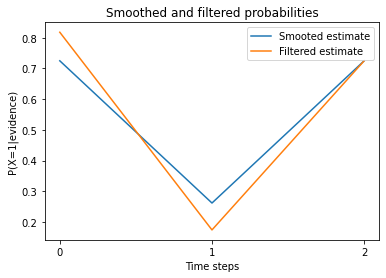

In [19]:
hmm.forward(data)
hmm.forward_backward(data)
hmm.visualize(1)
# smoothed looks more smooth, not so spiky

### Exercise 2
- explain how you will decide on which meteorologist you believe the most
in based on your observations.
    - meterologist: 1, weather stays same with 0.7 prob
    - meterologist: 2, weather stays same with 0.8 prob if not rain, if rain only 0.6 prob
    - data = obs = ⟨umb, umb, umb, umb, no-umb, no-umb, no-umb, umb, no-umb, no-umb⟩

- __Answer__:
    - To compute it we will compute $\text{P}(obs| \lambda_1)$ and $\text{P}(obs| \lambda_2)$
    - where $\lambda_i$ is the parameterizaton suggested by the transition models of meterologist i.
    - to do this it suffices to use the forward-propagation algorithm as written in (Rabiner, 1989),
      instead of multiplying just the probabilities, we will compute the log of the prob. hence we can use additions instead of multiplication to get numerical stability

- how would you use the HMM Python implementation to help you decide
on which of the two models/meteorologist to use. Also, what is the result
of the analysis?


- __Answer__:
    - so we need to call forward and then not need doing the normalization, which is similar to summing the ll
    - so just comparing the two hmm models by their ll, suggested by the respective meterologists will suffice

In [23]:
# paremeterizing the models 
trans_model1 = np.array([[0.7, 0.3], [0.3, 0.7]])
trans_model2 = np.array([[0.8, 0.2], [0.4, 0.6]])
 # not need below flip idea seems now
 # because we have rain = true as data value = 1, so need flip
 # similar to sensor data we also had flip
#trans_model2[[0,1]] = trans_model2[[1,0]]

prior_model = prior_model # as before
sensor_model = sensor_model # as before 
hmm_m1 = HMM(prior_model, trans_model1, sensor_model)
hmm_m2 = HMM(prior_model, trans_model2, sensor_model)
data = [1, 1, 1, 1, 0, 0, 0, 1, 0, 0]
hmm_m1.forward(data)
hmm_m2.forward(data)
print(f'Log likelihood of data given meterorlogist:')
print(f'Meterologist 1: {hmm_m1.ll}')
print(f'Meterologist 2: {hmm_m2.ll}')
print(f'Meterologist {np.argmax(np.array([hmm_m1.ll, hmm_m2.ll]))+1} wins')

Log likelihood of data given meterorlogist:
Meterologist 1: -9.403164354171803
Meterologist 2: -8.964803176252609
Meterologist 2 wins


### Exercise 3
- data
    - 1 : ⟨U1 = y, U2 = n, U3 = y⟩
    - 2 : ⟨U1 = y, U2 = n, U3 = n⟩
1. Trace (at a conceptual level) the steps that you will have to go through.

- __Answer__:
    - We need to do expectation and then modification repeatedly, to update the learned parameterization
<img src="images/hmm_parameter1.png" width=400/>
<img src="images/hmm_parameter2.png" width=400/>

    - Alg. sketch:
    - 1. do forward backward propagation
    - 2. update the new priors (which will not change)
    - 3. update the new transition probabilities, for example to comput P(rain_i=t|rain_i-1=t) we need to sum the respective probabilities for P(rain_i=t) from the forward-backward-messages

2. Use the python implementation to calculate the required probabilities.

In [25]:
# New transition matrix
def trans_model_hat(hmm, data):
    hmm.forward_backward(data)
    n_hidden = hmm.diag_sensor_model[0].shape[0]
    time = hmm.forward_messages.shape[1]
    trans_ij = np.zeros((time, n_hidden, n_hidden)) # P(R_t-1, R_t | x_i), hiddenStates X time
    # compute probabilities for transition from i to j at each t
    for t in range(time):
        trans_ij_t = trans_model * hmm.forward_backward_messages[:, t]
        trans_ij_t = hmm.diag_sensor_model[data[t]] @ trans_ij_t
        # normalize 
        trans_ij_t = trans_ij_t / trans_ij_t.sum(axis=1)[:, None]
        trans_ij[t,:] = trans_ij_t
    # Expectation + maximization
    # sum prob for P(R_t, R_t-1) and divide with P(R_t-1)
    new_trans_model = trans_ij.sum(axis=(0)) / trans_ij.sum(axis=(0,1))[:,None]
    return new_trans_model

In [26]:
# New prior, only 1 data example
def prior_hat(hmm, data):
    hmm.forward_backward(data)
    return hmm.forward_backward_messages[:,0] # np.array([0.5,0.5])

In [27]:
# New sensor model 
def sensor_model_hat(hmm, data, sensor_model):
    hmm.forward_backward(data)
    n_hidden = hmm.diag_sensor_model[0].shape[0]
    time = hmm.forward_messages.shape[1]
    trans_ij = np.zeros((time, n_hidden, n_hidden)) # P(R_t-1, R_t | x_i), hiddenStates X time
    # compute probabilities for transition from i to j at each t
    for t in range(time):
        trans_ij_t = trans_model * hmm.forward_backward_messages[:, t]
        trans_ij_t = hmm.diag_sensor_model[data[t]] @ trans_ij_t
        # normalize 
        trans_ij_t = trans_ij_t / trans_ij_t.sum(axis=1)[:, None]
        trans_ij[t,:] = trans_ij_t
    # Marginalize out P(R_t_-1)
    # sum prob for P(R_t, R_t-1) and divide with P(R_t-1)
    prob_state_j = trans_ij.sum(axis=(1))

    # Expectation + Maximization
    new_sensor_model = np.zeros(sensor_model.shape)
    umb_true_idx = np.arange(time)[np.asarray(data, dtype=bool)]
    umb_false_idx =np.arange(time)[~np.asarray(data, dtype=bool)]
    # P(U_t = umb | R_t)
    new_sensor_model[0,:] = prob_state_j[umb_true_idx].sum(axis=0) / prob_state_j.sum(axis=0)
    # P(U_t = no-umb | R_t)
    new_sensor_model[1,:] = prob_state_j[umb_false_idx].sum(axis=0) / prob_state_j.sum(axis=0)
    
    return new_sensor_model

3. Optional: Implement the algorithm in your HMM class in order to check
your results.

In [29]:
# combined alg. to update all parameters
def hmm_hat_k(hmm, data, prior_model,
            trans_model, sensor_model, k=1):
    # k is number of iterations to update
    hmm_hat = hmm
    for i in range(k):
        new_trans_model = trans_model_hat(hmm_hat, data)
        new_prior_model = prior_hat(hmm_hat, data)
        new_sensor_model = sensor_model_hat(hmm_hat, data, sensor_model)
        hmm_hat = HMM(new_prior_model, new_trans_model, new_sensor_model)
    
    return hmm_hat, (new_prior_model, new_trans_model, new_sensor_model)

In [45]:
# checking that likelihood of data is higher with new model
new_hmm, (new_prior_model, new_trans_model, new_sensor_model) = hmm_hat_k(hmm_m1, data, prior_model, trans_model, sensor_model, k=1)
hmm_m1.forward(data)
new_hmm.forward(data)
print(f'Log likelihood of data given new model:')
print(f'Old model (1): {hmm_m1.ll}')
print(f'New model (2): {new_hmm.ll}')
print(f'Meterologist {np.argmax(np.array([hmm_m1.ll, new_hmm.ll]))+1} wins')
# hmm not working too well, or above transition model not specified well?

Log likelihood of data given new model:
Old model (1): -9.403164354171803
New model (2): -11.384841688508654
Meterologist 1 wins


### Exercise 4

<img src="images/ml9_exc4.png" width=400/>

- Calculate the probability of P(S3 | O1 = 1.5, O2 = 3.8, O3 = 2.0).

S_t is specifying the continous means of the observations probs, with N(2*s_t,1)
- so that is why we do 2*1 and 2*2 in loc in the observation probs. matrices

In [31]:
from scipy.stats import norm
trans_m = np.array([[0.9, 0.1], [0.3, 0.7]]) # specify row wise 
prior = np.array([0.3, 0.7])
o1 = np.diag([norm.pdf(1.5, loc=2*1, scale=1), norm.pdf(1.5, loc=2*2, scale=1)])
o2 = np.diag([norm.pdf(3.8, loc=2*1, scale=1), norm.pdf(3.8, loc=2*2, scale=1)])
o3 = np.diag([norm.pdf(2.0, loc=2*1, scale=1), norm.pdf(2.0, loc=2*2, scale=1)])
obs = [o1, o2, o3]

In [32]:
# forward propagation
n_hidden = 2
time = 3
prob_state_j = np.zeros((n_hidden, time)) 

prob_state_j[:,0] = obs[0] @ prior
prob_state_j[:,0] = prob_state_j[:,0] / prob_state_j[:,0].sum()

for t in range(1, time):
    prob_state_j[:, t] = obs[t] @ (trans_m.T @ prob_state_j[:, t-1])
    prob_state_j[:, t] = prob_state_j[:, t] / prob_state_j[:, t].sum()
prob_state_j

array([[0.89592101, 0.51003112, 0.91913168],
       [0.10407899, 0.48996888, 0.08086832]])

- How should the Python class be adapted to accommodate the continuous
observations? Feel free to try to make the adjustment to solve the exercise
above.


__Answer__:

        - rather than indexing into the sensor_model, we should instantiate a diag matrix with the respective probabilities from the respective probability distributions here the gaussian